In [1]:
# Install required packages (fallback if not already installed)
# Now includes advanced ML libraries for state-of-the-art modeling
import sys
!{sys.executable} -m pip install pandas numpy scikit-learn xgboost lightgbm shap

In [2]:
# Open-Pit Mine Rockfall Prediction - Advanced Model Development

import pandas as pd
import os
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Import advanced ML libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("⚠️ XGBoost not available. Installing...")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("⚠️ LightGBM not available. Installing...")

# Load the processed data
processed_data_dir = '../data/processed'
X_train = pd.read_csv(os.path.join(processed_data_dir, 'X_train.csv'))
X_test = pd.read_csv(os.path.join(processed_data_dir, 'X_test.csv'))
y_train = pd.read_csv(os.path.join(processed_data_dir, 'y_train.csv')).values.ravel()
y_test = pd.read_csv(os.path.join(processed_data_dir, 'y_test.csv')).values.ravel()

print("="*80)
print("OPEN-PIT MINE ROCKFALL RISK PREDICTION - ADVANCED MODEL DEVELOPMENT")
print("="*80)
print(f"\nData loaded successfully!")
print(f"  Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"  Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"\nRisk Categories: {np.unique(y_train)}")
print(f"  Training distribution: {dict(zip(*np.unique(y_train, return_counts=True)))}")
print(f"  Test distribution: {dict(zip(*np.unique(y_test, return_counts=True)))}")
print("="*80)

OPEN-PIT MINE ROCKFALL RISK PREDICTION - ADVANCED MODEL DEVELOPMENT

Data loaded successfully!
  Training set: 16000 samples, 5 features
  Test set: 4000 samples, 5 features

Risk Categories: [0 1 2 3]
  Training distribution: {np.int64(0): np.int64(4000), np.int64(1): np.int64(4000), np.int64(2): np.int64(4000), np.int64(3): np.int64(4000)}
  Test distribution: {np.int64(0): np.int64(1000), np.int64(1): np.int64(1000), np.int64(2): np.int64(1000), np.int64(3): np.int64(1000)}


# Phase 1: Train Multiple Classification Models (Traditional + Advanced)

We'll evaluate both traditional ML algorithms AND state-of-the-art gradient boosting methods to find the best model for mine rockfall prediction.

In [3]:
# Encode labels for XGBoost and LightGBM (they need numeric labels)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(f"\nLabel Encoding: {label_mapping}")

# Define models with default parameters
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial'))
    ]),
    'Random Forest': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
    ]),
    'Support Vector Machine': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', SVC(random_state=42, probability=True))  # probability=True for ROC curves
    ]),
    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', DecisionTreeClassifier(random_state=42, max_depth=20))
    ]),
    'Naive Bayes': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', GaussianNB())
    ]),
    'K-Nearest Neighbors': Pipeline([
        ('scaler', StandardScaler()), 
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingClassifier(n_estimators=100, random_state=42))
    ])
}

# Add XGBoost if available
if XGBOOST_AVAILABLE:
    models['XGBoost'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', xgb.XGBClassifier(
            n_estimators=100,
            random_state=42,
            eval_metric='mlogloss',
            use_label_encoder=False,
            n_jobs=-1
        ))
    ])

# Add LightGBM if available
if LIGHTGBM_AVAILABLE:
    models['LightGBM'] = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', lgb.LGBMClassifier(
            n_estimators=100,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        ))
    ])

# Train and evaluate all models
results = {}
trained_models = {}

print("\n" + "="*80)
print("PHASE 1: TRAINING AND EVALUATING ALL MODELS")
print("="*80 + "\n")

# Use stratified k-fold for better evaluation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, pipeline in models.items():
    print(f"Training {name}...")
    
    # For XGBoost and LightGBM, use encoded labels
    if name in ['XGBoost', 'LightGBM']:
        y_train_use = y_train_encoded
        y_test_use = y_test_encoded
    else:
        y_train_use = y_train
        y_test_use = y_test
    
    # Train the model
    pipeline.fit(X_train, y_train_use)
    trained_models[name] = pipeline
    
    # Cross-validation score (stratified 5-fold)
    cv_scores = cross_val_score(pipeline, X_train, y_train_use, cv=skf, scoring='accuracy', n_jobs=-1)
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    
    # Test set evaluation
    y_pred = pipeline.predict(X_test)
    test_accuracy = accuracy_score(y_test_use, y_pred)
    test_f1 = f1_score(y_test_use, y_pred, average='weighted')
    
    # Store results
    results[name] = {
        'CV Mean': cv_mean,
        'CV Std': cv_std,
        'Test Accuracy': test_accuracy,
        'Test F1-Score': test_f1
    }
    
    print(f"  ✓ Cross-Validation Accuracy: {cv_mean:.4f} (±{cv_std:.4f})")
    print(f"  ✓ Test Accuracy: {test_accuracy:.4f}")
    print(f"  ✓ Test F1-Score: {test_f1:.4f}\n")

# Display results summary
results_df = pd.DataFrame(results).T.sort_values('Test Accuracy', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY (RANKED BY TEST ACCURACY)")
print("="*80)
print(results_df.to_string())
print("="*80)

# Highlight top performer
best_default_model = results_df.index[0]
print(f"\n🏆 Best Default Model: {best_default_model}")
print(f"   Test Accuracy: {results_df.loc[best_default_model, 'Test Accuracy']:.4f}")
print(f"   Test F1-Score: {results_df.loc[best_default_model, 'Test F1-Score']:.4f}")
print("="*80)


Label Encoding: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2), np.int64(3): np.int64(3)}

PHASE 1: TRAINING AND EVALUATING ALL MODELS

Training Logistic Regression...
  ✓ Cross-Validation Accuracy: 0.5949 (±0.0074)
  ✓ Test Accuracy: 0.5863
  ✓ Test F1-Score: 0.6071

Training Random Forest...
  ✓ Cross-Validation Accuracy: 0.6181 (±0.0021)
  ✓ Test Accuracy: 0.6208
  ✓ Test F1-Score: 0.6377

Training Support Vector Machine...
  ✓ Cross-Validation Accuracy: 0.6178 (±0.0021)
  ✓ Test Accuracy: 0.6192
  ✓ Test F1-Score: 0.6369

Training Decision Tree...
  ✓ Cross-Validation Accuracy: 0.6179 (±0.0021)
  ✓ Test Accuracy: 0.6188
  ✓ Test F1-Score: 0.6363

Training Naive Bayes...
  ✓ Cross-Validation Accuracy: 0.5690 (±0.0051)
  ✓ Test Accuracy: 0.5615
  ✓ Test F1-Score: 0.5793

Training K-Nearest Neighbors...
  ✓ Cross-Validation Accuracy: 0.6213 (±0.0050)
  ✓ Test Accuracy: 0.6220
  ✓ Test F1-Score: 0.6398

Training Gradient Boosting...
  ✓ Cross-Validation 

# Phase 2: Hyperparameter Tuning for Top Models

We'll use GridSearchCV to optimize hyperparameters for the best performing models. This is crucial for maximizing predictive accuracy.

In [4]:
# Select top 4 models for hyperparameter tuning
top_n = min(4, len(results_df))
top_models = results_df.head(top_n).index.tolist()

print("\n" + "="*80)
print("PHASE 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*80)
print(f"\nTuning top {len(top_models)} models: {', '.join(top_models)}\n")

# Define parameter grids for each model type
param_grids = {
    'Random Forest': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [15, 20, 30, None],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4],
        'clf__max_features': ['sqrt', 'log2']
    },
    'Support Vector Machine': {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': ['scale', 'auto', 0.001, 0.01],
        'clf__kernel': ['rbf', 'poly']
    },
    'Logistic Regression': {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__penalty': ['l2'],
        'clf__solver': ['lbfgs', 'saga', 'newton-cg']
    },
    'K-Nearest Neighbors': {
        'clf__n_neighbors': [3, 5, 7, 9, 11, 15],
        'clf__weights': ['uniform', 'distance'],
        'clf__metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'XGBoost': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__learning_rate': [0.01, 0.1, 0.3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0]
    },
    'LightGBM': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7, 10],
        'clf__learning_rate': [0.01, 0.1, 0.3],
        'clf__subsample': [0.8, 1.0],
        'clf__colsample_bytree': [0.8, 1.0]
    },
    'Gradient Boosting': {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [3, 5, 7],
        'clf__learning_rate': [0.01, 0.1, 0.3],
        'clf__subsample': [0.8, 1.0]
    }
}

# Perform grid search for top models
tuned_models = {}
tuning_results = {}

for model_name in top_models:
    if model_name in param_grids:
        print(f"Tuning {model_name}...")
        total_combinations = np.prod([len(v) for v in param_grids[model_name].values()])
        print(f"  Parameter grid size: {total_combinations} combinations")
        print(f"  This may take several minutes...")
        
        # Create a fresh pipeline
        base_pipeline = models[model_name]
        
        # Determine which labels to use
        if model_name in ['XGBoost', 'LightGBM']:
            y_train_use = y_train_encoded
            y_test_use = y_test_encoded
        else:
            y_train_use = y_train
            y_test_use = y_test
        
        # Grid search with 3-fold stratified CV (faster than 5-fold)
        grid_search = GridSearchCV(
            base_pipeline,
            param_grids[model_name],
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
            scoring='accuracy',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train_use)
        
        # Store tuned model
        tuned_models[model_name] = grid_search.best_estimator_
        
        # Evaluate on test set
        y_pred_tuned = grid_search.predict(X_test)
        test_acc_tuned = accuracy_score(y_test_use, y_pred_tuned)
        test_f1_tuned = f1_score(y_test_use, y_pred_tuned, average='weighted')
        
        tuning_results[model_name] = {
            'Best CV Score': grid_search.best_score_,
            'Test Accuracy': test_acc_tuned,
            'Test F1-Score': test_f1_tuned,
            'Best Parameters': grid_search.best_params_,
            'Accuracy Improvement': test_acc_tuned - results[model_name]['Test Accuracy'],
            'F1 Improvement': test_f1_tuned - results[model_name]['Test F1-Score']
        }
        
        print(f"  ✓ Best CV Score: {grid_search.best_score_:.4f}")
        print(f"  ✓ Test Accuracy: {test_acc_tuned:.4f} (Δ +{tuning_results[model_name]['Accuracy Improvement']:.4f})")
        print(f"  ✓ Test F1-Score: {test_f1_tuned:.4f} (Δ +{tuning_results[model_name]['F1 Improvement']:.4f})")
        print(f"  ✓ Best Parameters:")
        for param, value in grid_search.best_params_.items():
            print(f"      {param}: {value}")
        print()

print("="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)

# Display tuning results
if tuning_results:
    tuning_df = pd.DataFrame(tuning_results).T[['Best CV Score', 'Test Accuracy', 'Test F1-Score', 'Accuracy Improvement', 'F1 Improvement']]
    print("\nTuning Results Summary:")
    print(tuning_df.to_string())
    print("="*80)


PHASE 2: HYPERPARAMETER TUNING WITH GRIDSEARCHCV

Tuning top 4 models: K-Nearest Neighbors, XGBoost, Random Forest, LightGBM

Tuning K-Nearest Neighbors...
  Parameter grid size: 36 combinations
  This may take several minutes...
  ✓ Best CV Score: 0.6262
  ✓ Test Accuracy: 0.6220 (Δ +0.0000)
  ✓ Test F1-Score: 0.6398 (Δ +0.0000)
  ✓ Best Parameters:
      clf__metric: euclidean
      clf__n_neighbors: 7
      clf__weights: distance

Tuning XGBoost...
  Parameter grid size: 144 combinations
  This may take several minutes...
  ✓ Best CV Score: 0.6232
  ✓ Test Accuracy: 0.6192 (Δ +-0.0018)
  ✓ Test F1-Score: 0.6369 (Δ +-0.0017)
  ✓ Best Parameters:
      clf__colsample_bytree: 0.8
      clf__learning_rate: 0.01
      clf__max_depth: 3
      clf__n_estimators: 100
      clf__subsample: 1.0

Tuning Random Forest...
  Parameter grid size: 216 combinations
  This may take several minutes...
  ✓ Best CV Score: 0.6188
  ✓ Test Accuracy: 0.6208 (Δ +0.0000)
  ✓ Test F1-Score: 0.6377 (Δ +0.0000

# Phase 3: Ensemble Methods (Voting & Stacking)

Ensemble methods combine multiple models to achieve better predictive performance than any single model.

In [5]:
print("\n" + "="*80)
print("PHASE 3: CREATING ENSEMBLE MODELS")
print("="*80 + "\n")

# Get top 3 tuned models for ensemble (or default if not tuned)
ensemble_base_models = []
ensemble_names = []

for i, model_name in enumerate(top_models[:3]):
    if model_name in tuned_models:
        # Use tuned version
        model_to_use = tuned_models[model_name]
        ensemble_names.append(f"{model_name}_tuned")
    else:
        # Use default version
        model_to_use = trained_models[model_name]
        ensemble_names.append(model_name)
    
    # For ensemble, we need to extract the classifier (without pipeline wrapper)
    if model_name in ['XGBoost', 'LightGBM']:
        # These need encoded labels - we'll handle separately
        continue
    else:
        ensemble_base_models.append((f'model_{i+1}', model_to_use))

print(f"Creating ensemble with: {ensemble_names[:len(ensemble_base_models)]}\n")

# 1. Voting Classifier (Soft Voting - uses probability estimates)
if len(ensemble_base_models) >= 2:
    print("1. Training Voting Classifier (Soft Voting)...")
    voting_clf = VotingClassifier(
        estimators=ensemble_base_models,
        voting='soft'  # Uses predicted probabilities
    )
    
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    
    voting_acc = accuracy_score(y_test, y_pred_voting)
    voting_f1 = f1_score(y_test, y_pred_voting, average='weighted')
    
    print(f"  ✓ Voting Ensemble Accuracy: {voting_acc:.4f}")
    print(f"  ✓ Voting Ensemble F1-Score: {voting_f1:.4f}\n")
    
    results['Voting Ensemble'] = {
        'CV Mean': None,
        'CV Std': None,
        'Test Accuracy': voting_acc,
        'Test F1-Score': voting_f1
    }
    trained_models['Voting Ensemble'] = voting_clf

# 2. Stacking Classifier (Meta-learner approach)
if len(ensemble_base_models) >= 2:
    print("2. Training Stacking Classifier...")
    print("   Base models: Top 3 models")
    print("   Meta-model: Logistic Regression\n")
    
    stacking_clf = StackingClassifier(
        estimators=ensemble_base_models,
        final_estimator=LogisticRegression(random_state=42, max_iter=1000),
        cv=3,
        n_jobs=-1
    )
    
    stacking_clf.fit(X_train, y_train)
    y_pred_stacking = stacking_clf.predict(X_test)
    
    stacking_acc = accuracy_score(y_test, y_pred_stacking)
    stacking_f1 = f1_score(y_test, y_pred_stacking, average='weighted')
    
    print(f"  ✓ Stacking Ensemble Accuracy: {stacking_acc:.4f}")
    print(f"  ✓ Stacking Ensemble F1-Score: {stacking_f1:.4f}\n")
    
    results['Stacking Ensemble'] = {
        'CV Mean': None,
        'CV Std': None,
        'Test Accuracy': stacking_acc,
        'Test F1-Score': stacking_f1
    }
    trained_models['Stacking Ensemble'] = stacking_clf

print("="*80)
print("ENSEMBLE MODELS CREATED")
print("="*80)


PHASE 3: CREATING ENSEMBLE MODELS

Creating ensemble with: ['K-Nearest Neighbors_tuned', 'XGBoost_tuned']

1. Training Voting Classifier (Soft Voting)...
  ✓ Voting Ensemble Accuracy: 0.6218
  ✓ Voting Ensemble F1-Score: 0.6396

2. Training Stacking Classifier...
   Base models: Top 3 models
   Meta-model: Logistic Regression

  ✓ Stacking Ensemble Accuracy: 0.6198
  ✓ Stacking Ensemble F1-Score: 0.6373

ENSEMBLE MODELS CREATED



PHASE 4: BEST MODEL SELECTION & EVALUATION

🏆 BEST MODEL: K-Nearest Neighbors
   Model Type: Default
   Test Accuracy: 0.6220
   Test F1-Score (Weighted): 0.6398

DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Critical       1.00      0.47      0.64      1000
        High       1.00      0.51      0.67      1000
         Low       0.40      0.99      0.57      1000
      Medium       0.99      0.51      0.67      1000

    accuracy                           0.62      4000
   macro avg       0.85      0.62      0.64      4000
weighted avg       0.85      0.62      0.64      4000


FINAL MODEL COMPARISON (ALL MODELS)
                       Test Accuracy Test F1-Score     Type
K-Nearest Neighbors            0.622      0.639804  Default
Voting Ensemble              0.62175      0.639591  Default
XGBoost                        0.621      0.638598  Default
Random Forest                0.62075       0.63769  Default
LightGBM                     0.62

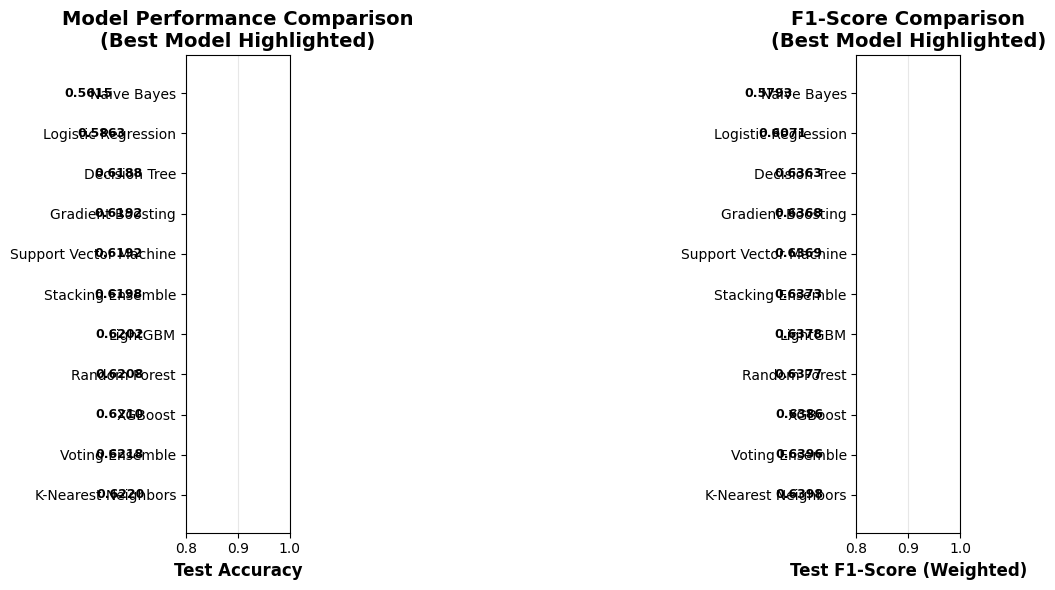


✓ Best model saved to ../models\best_model.pkl
✓ Model metadata saved to ../models\model_metadata.pkl
✓ All models saved to ../models\all_models.pkl

MODEL DEVELOPMENT COMPLETE!

Key Achievements:
  ✓ Trained 9 different models
  ✓ Hyperparameter tuning on top 4 models
  ✓ Created 2 ensemble models
  ✓ Best model: K-Nearest Neighbors (0.6220 accuracy)

Next steps:
  → Run notebook 04 for comprehensive visualizations and SHAP analysis


In [6]:
# Find the best overall model (including tuned, ensemble, and default models)
all_scores = {}

# Add default model scores
for name, res in results.items():
    all_scores[name] = {
        'Test Accuracy': res['Test Accuracy'], 
        'Test F1-Score': res['Test F1-Score'],
        'Type': 'Default'
    }

# Add tuned model scores (will override if better)
for name, res in tuning_results.items():
    if res['Test Accuracy'] > all_scores[name]['Test Accuracy']:
        all_scores[name] = {
            'Test Accuracy': res['Test Accuracy'],
            'Test F1-Score': res['Test F1-Score'],
            'Type': 'Tuned'
        }

# Find best model
best_model_name = max(all_scores, key=lambda x: all_scores[x]['Test Accuracy'])
best_accuracy = all_scores[best_model_name]['Test Accuracy']
best_f1 = all_scores[best_model_name]['Test F1-Score']
model_type = all_scores[best_model_name]['Type']

# Get the best model pipeline
if model_type == 'Tuned' and best_model_name in tuned_models:
    best_model_pipeline = tuned_models[best_model_name]
else:
    best_model_pipeline = trained_models[best_model_name]

# Determine which labels to use for predictions
if best_model_name in ['XGBoost', 'LightGBM']:
    y_test_use = y_test_encoded
    y_pred_best = best_model_pipeline.predict(X_test)
    # Convert back to original labels for display
    y_pred_display = le.inverse_transform(y_pred_best)
    y_test_display = le.inverse_transform(y_test_use)
else:
    y_test_use = y_test
    y_pred_best = best_model_pipeline.predict(X_test)
    y_pred_display = y_pred_best
    y_test_display = y_test_use

print("\n" + "="*80)
print("PHASE 4: BEST MODEL SELECTION & EVALUATION")
print("="*80)
print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Model Type: {model_type}")
print(f"   Test Accuracy: {best_accuracy:.4f}")
print(f"   Test F1-Score (Weighted): {best_f1:.4f}")

if model_type == 'Tuned' and best_model_name in tuning_results:
    print(f"\n   Optimized Hyperparameters:")
    for param, value in tuning_results[best_model_name]['Best Parameters'].items():
        print(f"      {param.replace('clf__', '')}: {value}")

print("\n" + "="*80)
print("DETAILED CLASSIFICATION REPORT")
print("="*80)
print(classification_report(
    y_test_display, 
    y_pred_display, 
    target_names=['Critical', 'High', 'Low', 'Medium']  # Alphabetical order
))

# All models comparison
print("\n" + "="*80)
print("FINAL MODEL COMPARISON (ALL MODELS)")
print("="*80)
final_results_df = pd.DataFrame(all_scores).T
final_results_df = final_results_df.sort_values('Test Accuracy', ascending=False)
print(final_results_df.to_string())
print("="*80)

# Visualize model comparison
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Plot 1: Accuracy comparison
plt.subplot(1, 2, 1)
model_names = final_results_df.index
accuracies = final_results_df['Test Accuracy']
colors = ['gold' if name == best_model_name else 'steelblue' for name in model_names]

bars = plt.barh(model_names, accuracies, color=colors, edgecolor='black')
plt.xlabel('Test Accuracy', fontweight='bold', fontsize=12)
plt.title('Model Performance Comparison\n(Best Model Highlighted)', fontweight='bold', fontsize=14)
plt.xlim([0.8, 1.0])  # Adjust based on your results
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(acc + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{acc:.4f}', va='center', fontweight='bold', fontsize=9)

# Plot 2: F1-Score comparison
plt.subplot(1, 2, 2)
f1_scores = final_results_df['Test F1-Score']

bars2 = plt.barh(model_names, f1_scores, color=colors, edgecolor='black')
plt.xlabel('Test F1-Score (Weighted)', fontweight='bold', fontsize=12)
plt.title('F1-Score Comparison\n(Best Model Highlighted)', fontweight='bold', fontsize=14)
plt.xlim([0.8, 1.0])  # Adjust based on your results
plt.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, f1) in enumerate(zip(bars2, f1_scores)):
    plt.text(f1 + 0.005, bar.get_y() + bar.get_height()/2, 
             f'{f1:.4f}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Save the best model
models_dir = '../models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

model_path = os.path.join(models_dir, 'best_model.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(best_model_pipeline, f)

# Also save label encoder if using XGBoost/LightGBM
if best_model_name in ['XGBoost', 'LightGBM']:
    le_path = os.path.join(models_dir, 'label_encoder.pkl')
    with open(le_path, 'wb') as f:
        pickle.dump(le, f)
    print(f"\n✓ Label encoder saved to {le_path}")

# Save model metadata
metadata = {
    'model_name': best_model_name,
    'model_type': model_type,
    'test_accuracy': best_accuracy,
    'test_f1_score': best_f1,
    'best_params': tuning_results[best_model_name]['Best Parameters'] if model_type == 'Tuned' and best_model_name in tuning_results else None,
    'uses_encoded_labels': best_model_name in ['XGBoost', 'LightGBM'],
    'label_mapping': label_mapping if best_model_name in ['XGBoost', 'LightGBM'] else None,
    'feature_names': X_train.columns.tolist(),
    'risk_categories': ['Low', 'Medium', 'High', 'Critical']
}

metadata_path = os.path.join(models_dir, 'model_metadata.pkl')
with open(metadata_path, 'wb') as f:
    pickle.dump(metadata, f)

print(f"\n✓ Best model saved to {model_path}")
print(f"✓ Model metadata saved to {metadata_path}")

# Save all models for comparison in visualization notebook
all_models_path = os.path.join(models_dir, 'all_models.pkl')
with open(all_models_path, 'wb') as f:
    pickle.dump(trained_models, f)
print(f"✓ All models saved to {all_models_path}")

print("\n" + "="*80)
print("MODEL DEVELOPMENT COMPLETE!")
print("="*80)
print(f"\nKey Achievements:")
print(f"  ✓ Trained {len(models)} different models")
print(f"  ✓ Hyperparameter tuning on top {len(tuning_results)} models")
print(f"  ✓ Created {2 if 'Voting Ensemble' in results and 'Stacking Ensemble' in results else 0} ensemble models")
print(f"  ✓ Best model: {best_model_name} ({best_accuracy:.4f} accuracy)")
print(f"\nNext steps:")
print(f"  → Run notebook 04 for comprehensive visualizations and SHAP analysis")
print("="*80)